In [9]:
import deepxde as dde
import copy
import numpy as np
from utils import update_collocation, plot_pts, plot_flowfield, eval_pde_loss, remove_figs_models
from train_PINN import get_NN, train_PINN
from geom_bcs.Lid_Driven import get_liddriven_geom_bcs

dde.config.set_random_seed(42)
# remove_figs_models()


def liddriven_pde(x, u):
    nu = 0.01
    u_vel, v_vel, _ = u[:, [0]], u[:, [1]], u[:, [2]]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
    momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

geom, bcs = get_liddriven_geom_bcs()
data = dde.data.PDE(geom, liddriven_pde, bcs, num_domain=100, num_boundary=100, num_test=5000, train_distribution='LHS')

N_adapt_ = 20
compile_kwargs_ = {"optimizer":"adam", "lr":1e-3}
adam_iterations_ = [5000]*3
lbfgs_iterations_ = None
lbfgs_iterations_ = [0,0,0]
network_kwars_ = {"layer_size" : [2] + [40] * 5 + [3],
              "activation" : 'tanh',
              "initializer" : 'Glorot uniform'}
#########################################################################
"""
Vanilla
"""
net = get_NN(**network_kwars_)

data_vanilla = copy.deepcopy(data)
model_vanilla = dde.Model(data_vanilla, net)
model_vanilla.compile(**compile_kwargs_)

model_vanilla.restore("./saved_models/Van-10000.pt")

Compiling model...
'compile' took 0.000078 s



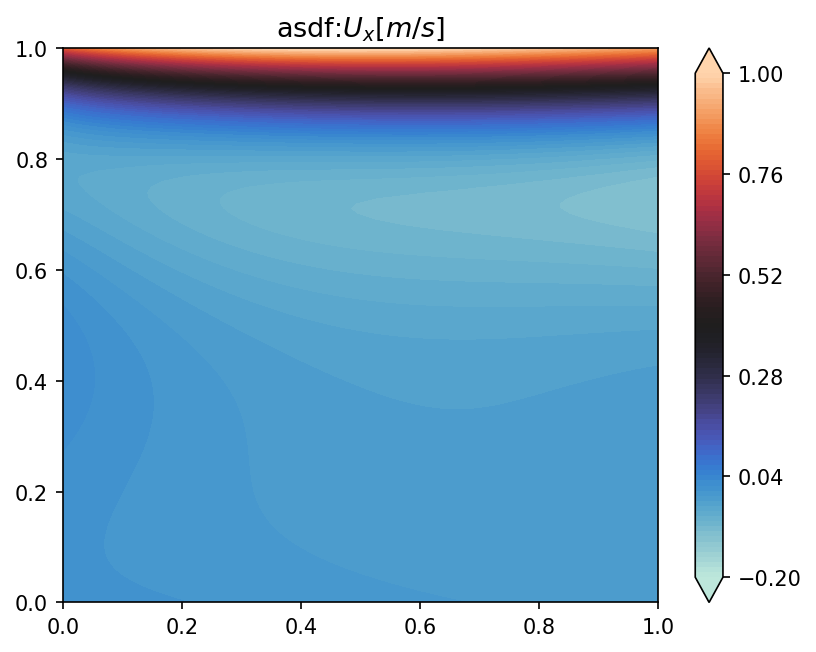

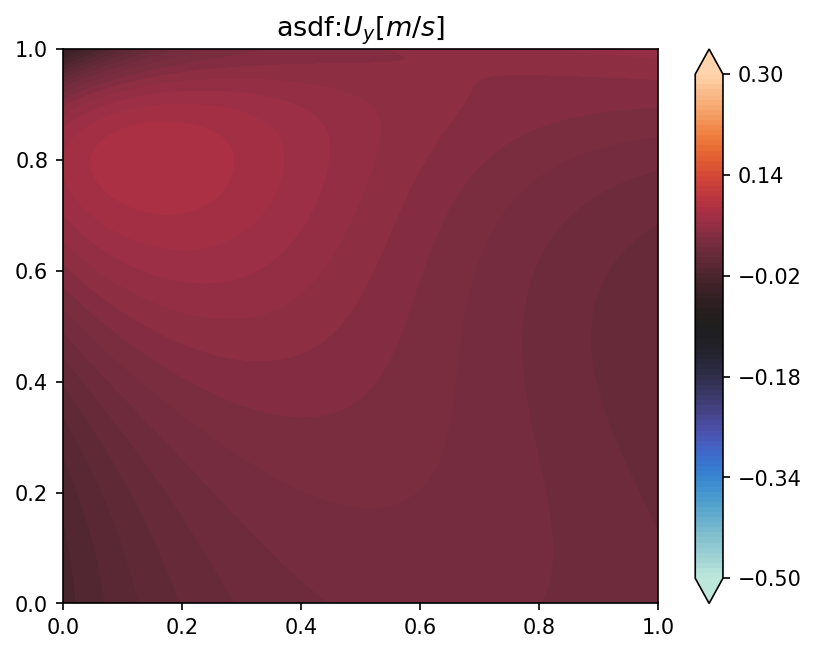

In [8]:
x1_test = np.linspace(0, 1, 101)
x2_test = np.linspace(0, 1, 101)
X_test = np.zeros((len(x1_test)*len(x2_test), 2))
X_test[:, 0] = np.vstack((x1_test,)*len(x2_test)).reshape(-1)
X_test[:, 1] = np.vstack((x2_test,)*len(x1_test)).T.reshape(-1)

Y_test = model_vanilla.predict(X_test)


plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test[:,0], y2=Y_test[:,1], tag='asdf', stream=False, initialize_levels=False)

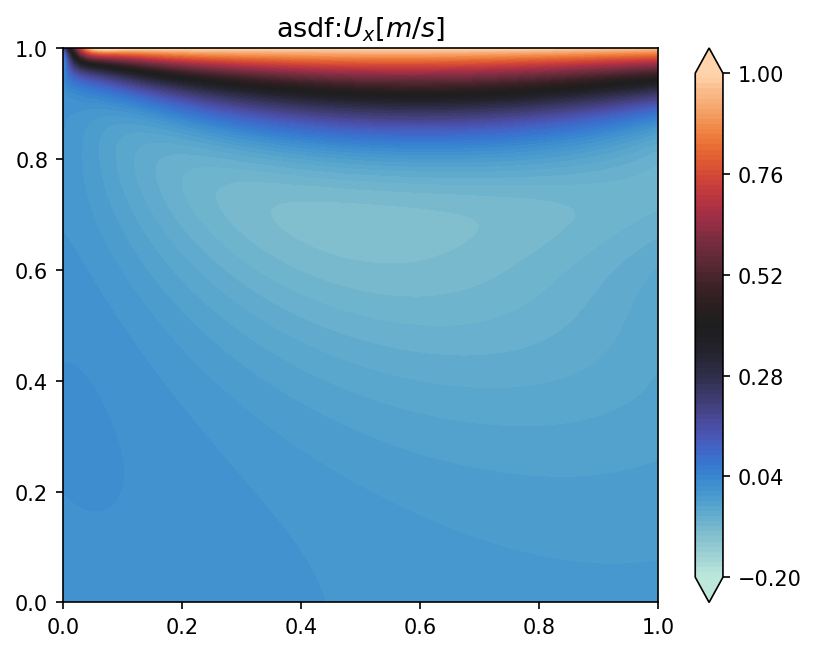

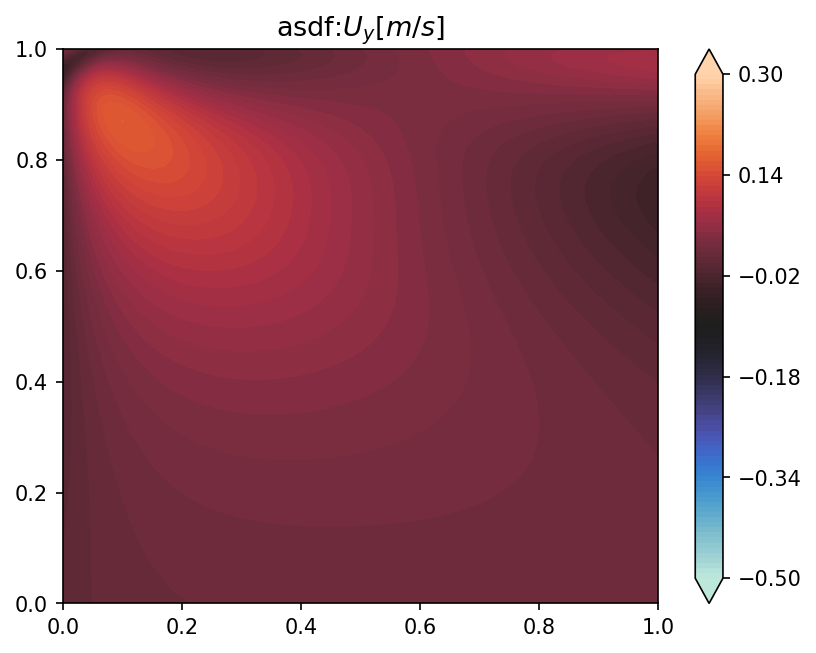

In [10]:
x1_test = np.linspace(0, 1, 101)
x2_test = np.linspace(0, 1, 101)
X_test = np.zeros((len(x1_test)*len(x2_test), 2))
X_test[:, 0] = np.vstack((x1_test,)*len(x2_test)).reshape(-1)
X_test[:, 1] = np.vstack((x2_test,)*len(x1_test)).T.reshape(-1)

Y_test = model_vanilla.predict(X_test)


plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test[:,0], y2=Y_test[:,1], tag='asdf', stream=False, initialize_levels=False)